# Image processing of a 4-tank instrument available at Chemical Engineering Lab, Department of Chemical Engineering, IIT Bombay

In [43]:
from matplotlib import pyplot as plt
import numpy as np

# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

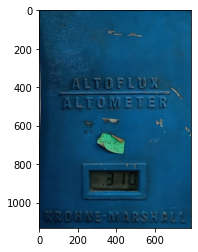

In [44]:
orig_image=cv2.imread("../data/lab_image.jpg")

orig_image=cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
plt.imshow(orig_image)

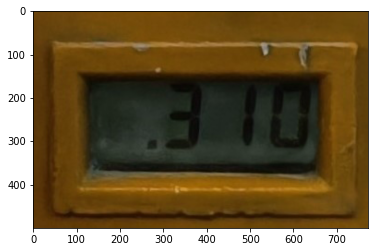

In [45]:
# load the example image
image = cv2.imread("num.jpg")
# pre-process the image by resizing it
image = imutils.resize(image, height=500)
plt.imshow(image)

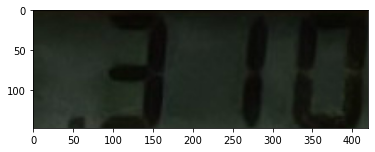

In [46]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

displayCnt=np.array([[220, 162],
       [220, 310],
       [640, 310],
       [640, 162]])
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))
plt.imshow(output)

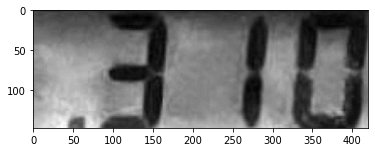

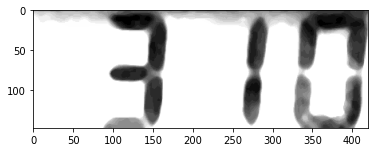

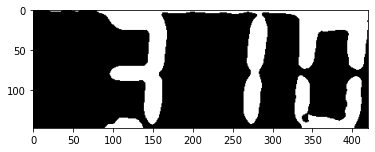

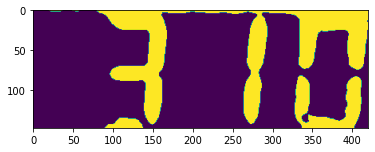

In [47]:
# img = cv2.imread(img_path)
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# lower_gray = np.array([0, 5, 50], np.uint8)
# upper_gray = np.array([179, 50, 255], np.uint8)
# mask_gray = cv2.inRange(hsv, lower_gray, upper_gray)
# img_res = cv2.bitwise_and(img, img, mask = mask_gray)
gray = warped
plt.imshow(gray, cmap="gray")
plt.show()

adjusted = cv2.convertScaleAbs(gray, alpha=9, beta=20)

median = cv2.medianBlur(adjusted, 9)
plt.imshow(median, cmap="gray")
plt.show()

thresh_with_grey = cv2.threshold(median, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh_with_grey, cmap="gray")
plt.show()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
thresh_with_grey = cv2.morphologyEx(thresh_with_grey, cv2.MORPH_OPEN, kernel)
plt.imshow(thresh_with_grey)
plt.show()

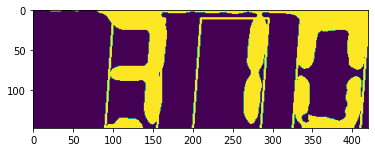

In [48]:
import numpy

contours = [numpy.array([[90,150],[155,150],[165,10], [100,10]], dtype=numpy.int32),numpy.array([[200,150],[285,150],[295,10], [210,10]], dtype=numpy.int32) ,numpy.array([[325,150],[410,150],[420,10], [335,10]], dtype=numpy.int32)]

drawing = thresh_with_grey.copy()
for cnt in contours:
    cv2.drawContours(drawing,[cnt],0,(255,255,0),2)

plt.imshow(drawing)
digitCnts=contours
thresh=thresh_with_grey

In [49]:
digits = []
len(digitCnts)

3

In [56]:
# loop over each of the digits
for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y + h, x:x + w]
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)
    # loop over the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        # if the total number of non-zero pixels is greater than
        # 50% of the area, mark the segment as "on"
        if total / float(area) > 0.4:
            on[i]= 1
    # lookup the digit and draw it on the image
    try:
        digit = DIGITS_LOOKUP[tuple(on)]
        digits.append(digit)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
#         print(x, y)
        cv2.putText(output, str(digit), (x + 30, y + 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
        print("identified tuple",on)
        print("and identified digit=",digit)
    except:
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)
            # if the total number of non-zero pixels is greater than
            # 30% of the area, mark the segment as "on"
            if total / float(area) > 0.3:
                on[i]= 1
#         print(on)
        try:
            digit = DIGITS_LOOKUP[tuple(on)]
            digits.append(digit)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv2.putText(output, str(digit), (x + 20, y + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
            print("identified tuple",on)
            print("and identified digit=",digit)
        except:
            print('No digit found')

identified tuple [1, 0, 1, 1, 0, 1, 1]
and identified digit= 3
identified tuple [0, 0, 1, 0, 0, 1, 0]
and identified digit= 1
identified tuple [1, 1, 1, 0, 1, 1, 1]
and identified digit= 0


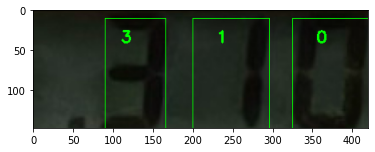

In [51]:
plt.imshow(output)